# Forest Cover Case Study

## Introduction:

Rasterframes is a powerful tool for combining geospatial data and spark dataframes. In this case study, we will walk through using rasterframes to conduct analysis of a forested region to determine the extent of deforestation using NDVI (Normalized Difference Vegetation Index) combined with basic machine learning techniques available through SparkML. This tutorial assumes a basic knowledge of dataframes, more info can be found [here](https://spark.apache.org/docs/latest/sql-programming-guide.html#datasets-and-dataframes): 
## Background:

As humans expand across the planet, land that was once forested is cleared for other activities such as farming or logging. Such land is often high in biodiversity, and while our forests are an essential feature in our ecosystem, they are being destroyed at an unsustainable rate. Gathering data on the precise regions in which this destruction is occurring allows scientists and authorities to more easily combat deforestation. Satellite data can be utilized to track and prevent deforestation, as demonstrated by this tutorial, which uses an example from the Amazon rainforest.

## Initializing the environment:

First, some imports must be made. The rasterframes library must be imported as well as pyspark, which serves as the processing backbone of rasterframes. 

In [1]:
from pyrasterframes import *
from pyrasterframes.rasterfunctions import *
import pyspark
from pyspark.sql import SparkSession

Once the imports have been made, a `sparkSession` must be created. Note the `withRasterFrames()` method that is called which enables access to the rasterframes API.

In [2]:
spark = SparkSession.builder. \
    master("local[*]"). \
    appName("RasterFrames"). \
    config("spark.ui.enabled", "false"). \
    getOrCreate(). \
    withRasterFrames()

## Reading in a Rasterframe

Once everything has been initialized, the next step is to read in our data. This example will use data in the form of a GeoTiff, but there are other ways to create a rasterframe, including from a geotrellis `Layer`, `ProjectedExtent`, or `tileLayerRDD` (see [creating-rasterframes](../Minis/creating-rasterframes.html) for more info). In the case of a geotiff, it's as simple as pointing spark.read.geotiff to the input file(s).

In [3]:
filePath = 'data/brazil_1/band2.tif'
initRF = spark.read.geotiff(filePath)

## Initial analysis

Immediately, we can perform some basic functions on this rasterframe. A brief `.show()` or `.toPandas()` will demonstrate that a RasterFrame is very similar to a dataframe, with named columns corresponding to certain attributes. For instance, `tile` contains all the cell values of the image. `bounds` contains the bounds of the tiff's geometry, etc. In this way, a tiff raster is represented as a rasterframe.

In [4]:
initRF.toPandas()

,spatial_key,bounds,metadata,tile
0,"(0, 0)","POLYGON ((746445 -980235, 746445 -973365, 7531...","{'Band_1': 'band 2 surface reflectance', 'AREA...","ShortUserDefinedNoDataArrayTile([S@65854fb7,22..."


We can conduct some initial analysis on the tile column by calling `tileStats` on it. The output is an array with the number of cells, number of noDataCells, min, max, mean, and variance respectively (for more on tile statistics, see [tile statistics](../Minis/statistics.html)). 

In [5]:
initRF.select(tileStats("tile")).show(truncate = False)

+----------------------------------------------------------+
|tileStats(tile)                                           |
+----------------------------------------------------------+
|[51525,-1,125.0,726.0,237.8598544395925,4944.952683336407]|
+----------------------------------------------------------+



We can examine the cell type of a tile with the `cellType` command.

In [6]:
initRF.select(cellType("tile")).show()

+------------------------+
|celltypeexpression(tile)|
+------------------------+
|            int16ud-9999|
+------------------------+



Individual stats about a tile can be obtained through the family of methods including `tileMean`, `tileSum`, `tileMin`, etc. You'll notice the output of `tileMean` is consistent with the mean value found with `tileStats`.

In [7]:
initRF.select(tileMean("tile")).show()

+------------------+
|    tileMean(tile)|
+------------------+
|237.85985443959243|
+------------------+



## Loading the rest of the bands

This image is a multiband image, but we are going to load in each band individually and then perform a spatial join on the bands. This allows us to get all the bands in one rasterframe. For this demo, we are using visual and near infrared light to perform feature engineering and then unsupervised clustering on the dataset. This means that we are loading in bands 2 through 5, which correspond to Blue, Green, Red, and NIR on the [Landsat 8 OLI](https://lta.cr.usgs.gov/L8). `spatialJoin` is a RasterFrame join that joins according to a spatial_key column. Bounds and metadata are discarded because they are no longer useful for the project.

This project analyzes three seperate scenes, all captured in close proximity to each other in the Brazilian rainforest. The background of this image is the green band, and it seems obvious from a brief look at this band that there is deforestation occurring at all three sites.

![Pic](pics/site_locs.png)

In [9]:
# Three scenes
scene_nums = range(1, 4)
# Four bands per scene (2, 3, 4, and 5)
band_nums = range(2, 6)

filePattern = 'data/brazil_{0}/band{1}.tif'

def readTiff(name):
    return spark.read.geotiff(name)

from functools import reduce

#Start from the bottom

# Join those singleband rasterframes together into a multiband RF
fullRFs = [reduce(lambda rf1, rf2: rf1.asRF().spatialJoin(rf2), 
    # Map those tuples to the singleband rasterframe file with the default "tile" column renamed  
    [readTiff(bf[1]).withColumnRenamed('tile', 'band_{}'.format(bf[0])) for bf in \
    # Map the bandNumbers to (bandNumber, formatted file name) tuples
    [(bn, filePattern.format(sn, bn)) for bn in band_nums]]) \
    # Drop unnecessary columns
    .drop('bounds').drop('metadata') for sn in scene_nums]

As you can see, all four bands of all three scenes are now loaded into three seperate rasterframes.

In [10]:
for rf in fullRFs:
    rf.asRF().show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+--------------------+--------------------+--------------------+--------------------+
|spatial_key|              band_2|              band_3|              band_4|              band_5|
+-----------+--------------------+--------------------+--------------------+--------------------+
|      [0,0]|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|ShortUserDefinedN...|
+-----------+--------------------+--------------------+--------------------+--------------------+

+-----------+-----

In addition, it is possible to display the center of the extent of the tile in (Lat, Long) format. The method `withCenter` will display it in the native CRS, and `withBounds` and `withSpatialIndex` also exist.

In [11]:
for rf in fullRFs:
    rf.asRF().withCenterLatLng().select("center").show(truncate=False)

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.72875437318221,-8.829838122908235]|
+---------------------------------------+

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.96294012022688,-8.904540118090805]|
+---------------------------------------+

+---------------------------------------+
|center                                 |
+---------------------------------------+
|[-66.89073947264485,-8.725024074332008]|
+---------------------------------------+



## Feature Engineering

This example uses [NDVI](../Minis/ndvi.html), which is a metric computed from the normalized difference between two of our bands, the NIR band (band 5), and the red band (band 4). We will add another column, this time with the tiles as the normalized difference between the NIR and red bands for each scene. In addition, it is sometimes useful to compute additional relationships between bands to use as features in a machine learning algorithm. Additionally, the cell types of the NIR and red bands are converted to floats for the purposes of stability with `convertCellType`, which changes the data type of the cells in a tile. The diagram below is a local function that operates on colors (See [Tile Arithmetic](../Minis/tile-arithmetic.html) for more information on map algebra).
![Local Function](pics/local-functions.gif)

In [12]:
ndviRFs = [rf.withColumn("ndvi", normalizedDifference(
    convertCellType('band_5', 'float32'), 
    convertCellType('band_4', 'float32'))) for rf in fullRFs]

Normalized difference is a local function that is equivalent to $\frac{NIR - Red}{NIR + Red}$. Local functions perform functions on a cellwise basis. Every cell in a band has corresponding cells in another band, and the output of a local function is a tile where the cell values are determined by some function that operates on every cell individually. GRVI is another vegetation index similar to NDVI which is the normalized difference between the green and red bands.

In [13]:
completedRFs = [rf.withColumn("grvi", normalizedDifference(
    convertCellType('band_3', 'float32'), 
    convertCellType('band_4', 'float32'))) for rf in ndviRFs]

## Machine learning

The purpose of this demonstration is to determine the extent of deforestation in the selected areas in a procedural way. To this end, we will use a straightforward [k-means](https://en.wikipedia.org/wiki/K-means_clustering) clustering algorithm available to us through SparkML. K-means operates by establishing k cluster centers and then assigning every observation to a cluster based on the distance it is from the cluster center. The location of the cluster centers are moved to be the centroid of the observations, and the process is repeated until convergence occurs (For another example of clustering, see [clustering](../Minis/clustering.html)). 

These are the tile stats for the NDVI, GRVI, and infrared bands in the first scene.

In [14]:
completedRFs[0].select(tileStats("ndvi")).show(truncate = False)
completedRFs[0].select(tileStats("grvi")).show(truncate = False)
completedRFs[0].select(tileStats("band_5")).show(truncate = False)

+----------------------------------------------------------------------------------------+
|tileStats(ndvi)                                                                         |
+----------------------------------------------------------------------------------------+
|[51525,-1,0.2584196925163269,0.9273137450218201,0.8077649412792555,0.008396342462181239]|
+----------------------------------------------------------------------------------------+

+-------------------------------------------------------------------------------------------+
|tileStats(grvi)                                                                            |
+-------------------------------------------------------------------------------------------+
|[51525,-1,-0.16288061439990997,0.3622449040412903,0.17350494746009204,0.009846214924387444]|
+-------------------------------------------------------------------------------------------+

+------------------------------------------------------------+
|tileStats

Recall that k-means uses the euclidean distance between two features to assign cluster values to each cell, which is the distance in 6 dimensional space where the six feature dimensions are the four bands and the two indexes we created. However, as we can see from the tile stats, ndvi and grvi are between 0 and 1 while the bands have values in the thousands. This means that the distance between any two points will be largely determined by the band values, which defeats the point of using our vegetation indexes. One solution is to also convert the values of the bands to be between 0 and 1.

In [15]:
scaledRFs = [rf.withColumn("ndvi_s", localMultiplyScalar("ndvi", 500.0)) \
    .withColumn("grvi_s", localMultiplyScalar("grvi", 500.0)) for rf in completedRFs]

### Pipeline

The algorithm works through assigning features to clusters. PySparkML requires that each feature be in its own row, and those features be packed into a single `Vector`. This means that all the information must be packed into a single feature vector. The first step is to "explode" the tiles into a single row per cell/pixel, so the top left cell is assigned its own row, with the cellwise values of every band as the values in that row.

In [17]:
exploder = TileExploder()

band_col_names = ["band_{}".format(x) for x in band_nums]

The next step is for the cell values in their seperate columns to be assembled into a single feature vector. PySparkML has a tool for this called a `VectorAssembler` which has as inputs a certain number of columns of features and outputs a single column with the vectorized features in it.

In [18]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler() \
    .setInputCols(band_col_names + [("ndvi_s")] + [("grvi_s")]) \
    .setOutputCol("features")

For our example we are setting the number of clusters to 3.

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

kmeans = KMeans().setK(3)

# We establish our pipeline with our stages
pipeline = Pipeline().setStages([exploder, assembler, kmeans])

Finally, we fit our model and compute our clusters

In [20]:
models = [pipeline.fit(rf) for rf in scaledRFs]

Upon fitting the model and transforming the data, we see the exploded data. Instead of a tile, every entry in a band contain a single pixel value. In addition, there is a prediction column that contains the result of the model's clustering.

In [21]:
rf_model_zip = list(zip(scaledRFs, models))

clusteredRFs = [rf_models[1].transform(rf_models[0]) for rf_models in rf_model_zip]
clusteredRFs[0].show(3)

+-----------+------------+---------+------+------+------+------+------------------+-------------------+------------------+------------------+--------------------+----------+
|spatial_key|column_index|row_index|band_2|band_3|band_4|band_5|              ndvi|               grvi|            ndvi_s|            grvi_s|            features|prediction|
+-----------+------------+---------+------+------+------+------+------------------+-------------------+------------------+------------------+--------------------+----------+
|      [0,0]|           0|        0| 188.0| 349.0| 206.0|2750.0|0.8606224656105042|0.25765764713287354|430.31121826171875|128.82882690429688|[188.0,349.0,206....|         0|
|      [0,0]|           1|        0| 184.0| 340.0| 207.0|2837.0|0.8639947175979614| 0.2431444227695465| 431.9973449707031|121.57221221923828|[184.0,340.0,207....|         0|
|      [0,0]|           2|        0| 196.0| 356.0| 227.0|2856.0|0.8527408242225647|0.22126929461956024|426.37042236328125| 110.634

## Visualizing Results

In order to visualize the predictions of our model, we must first convert the exploded version of the tile back into an actual tile.

In [22]:
tiledRFs = list()
for i in range(0, 3):
    tlm = completedRFs[i].asRF().tileLayerMetadata()
    layout = tlm['layoutDefinition']['tileLayout']

    retiled = clusteredRFs[i].groupBy('spatial_key').agg(
        assembleTile('column_index', 'row_index', 'prediction',
        layout['tileCols'], layout['tileRows'], 'int16'))
        
    tiledRFs.append(retiled)

predRFs = [rf.asRF('spatial_key', tlm) for rf in tiledRFs]
for rf in predRFs:
    rf.show(3)

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+

+-----------+--------------------+
|spatial_key|          prediction|
+-----------+--------------------+
|      [0,0]|ShortConstantNoDa...|
+-----------+--------------------+



To render our visualization, we convert to a raster first, which gives us a 1-D array with all the cell values. We then reshape the raster into a 2d array and use an
matplotlib colormap to assign each discrete cluster a different color.

In [23]:
resolutions = ((229, 225), (232, 246), (235, 231))

Zip the prediction RFs and their respective resolutions to prepare to render them

In [24]:
zip_preds_res = list(zip(predRFs, resolutions))

Create a one dimensional array from the prediction data

In [38]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

rasters = [np.asarray(list(pred_res[0].select(
          tileToIntArray('prediction')).first())) for pred_res in zip_preds_res]

Zip the prediction RFs and their respective resolutions to prepare to render them

In [29]:
zipRasterResolution = list(zip(rasters, resolutions))

Reshape the array into a two dimensional array to be fed into matplotlib.

In [30]:
pixels = [np.reshape(RasRes[0], RasRes[1]) for RasRes in zipRasterResolution]

pixels[2]

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [1, 0, 0, ..., 2, 2, 2],
       ..., 
       [2, 2, 2, ..., 1, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

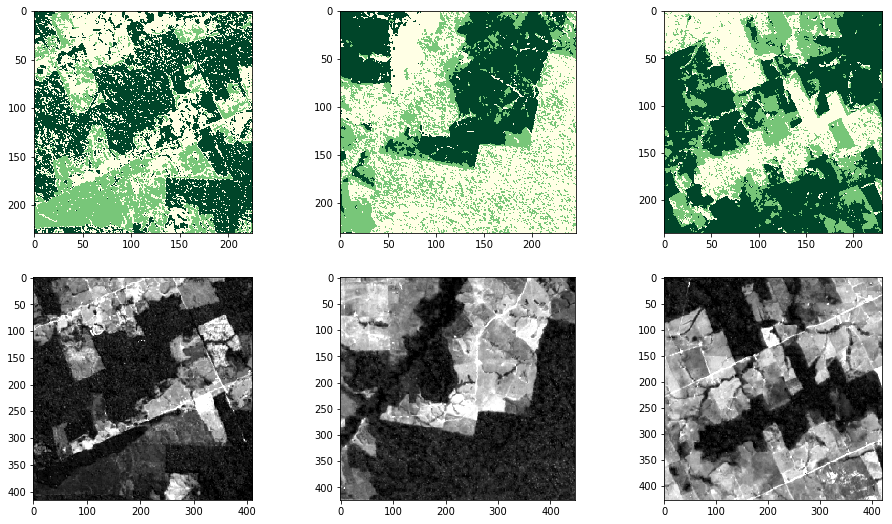

In [32]:
# Plot the images
cmap = "YlGn_r"
fig = plt.figure(figsize=(16,9))
fig.add_subplot(2, 3, 1)
plt.imshow(pixels[0])
plt.set_cmap(cmap)
fig.add_subplot(2, 3, 2)
plt.imshow(pixels[1])
plt.set_cmap(cmap)
# Flip the colormap because the last scene has the cluster values reversed
cmap = "YlGn"
fig.add_subplot(2, 3, 3)
plt.imshow(pixels[2])
plt.set_cmap(cmap)

fig.add_subplot(2, 3, 4)
pixels4 = mpl.pyplot.imread("pics/brazil1-green.png")
plt.imshow(pixels4)
fig.add_subplot(2, 3, 5)
pixels5 = mpl.pyplot.imread("pics/brazil2-green.png")
plt.imshow(pixels5)
fig.add_subplot(2, 3, 6)
pixels6 = mpl.pyplot.imread("pics/brazil3-green.png")
plt.imshow(pixels6)

As you can see, the dark green represents forest, with the other two shades representing land that is cleared to some degree. Now let's access more precise statistics about this use. `tileHistogram` creates a histogram based on the cell values of a tile. The first section contains statistics in the form of `tileStats`, and the second element is an array bins, which consist of (value, number) tuples.

In [34]:
predRFs[0].select(tileHistogram("prediction")).show(truncate = False)

predRFs[2].select(tileHistogram("prediction")).show(truncate = False)

+--------------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                     |
+--------------------------------------------------------------------------------------------------------------+
|[[51525,-1,0.0,2.0,0.9078311499272198,0.7740182461136218],WrappedArray([0.0,22534], [1.0,11206], [2.0,17785])]|
+--------------------------------------------------------------------------------------------------------------+

+-------------------------------------------------------------------------------------------------------------+
|tileHistogram(prediction)                                                                                    |
+-------------------------------------------------------------------------------------------------------------+
|[[54285,-1,0.0,2.0,1.2149765128488532,0.697047510270865],WrappedArray([0.0,14339], [1.0,13937], [

In these examples, it appears that a value of zero (Dark Green in the colormap) represents forest. Let's find the percentage of land covered by forest in these examples. Recall that rasters is the list of one dimensional arrays containing all the prediction values for the three scenes.

In [1]:
# Returns the number of cells that we believe the model marked similarly to forest
forest1 = np.count_nonzero(rasters[0] == 0)
# The second scene has forest values set to 1
forest2 = np.count_nonzero(rasters[1] == 1)
# The third scene has the clusters reversed, so we look for values of 2
forest3 = np.count_nonzero(rasters[2] == 2)

NameError: name 'np' is not defined

In the first scene, a little less than half of the scene is composed of the values that resemble rainforest (according to the model).

In [36]:
# Number of forest divided by the total
forest1 / len(rasters[0])

22534.0

In [37]:
# Total forest cells for all three scenes, divided by total cells
(forest1 + forest2 + forest3) / (len(rasters[0]) + len(rasters[1]) + len(rasters[2]))

21003.666666666668

In total, it appears that less than 40 percent of the area surveyed in these three scenes is forested. While there are improvements to be made, this algorithm could easily be adapted to survey land of any size. Landsat 8 has a temporal resolution of 16 days, and tracking these numbers over time could give an estimate of the rate of change of deforestation in a certain area, or with enough compute power, the entire Amazon Rainforest.